---

This notebook contains code to re-create **Figure 11** from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, D. Tabb, Miguel Carcamo & Joe Hanson

**Note:** The flagging and noise realisations implemented in this notebook are stochastic, so the figure will have the same properties as the one that appears in the paper but is unlikely to be identical.

---

In [1]:
import autograd.numpy as np
import pylab as pl
import os,sys
from tqdm import tqdm_notebook

In [2]:
from faraday_models import *
from faraday_stuff import *
from celerite_base import *

In [3]:
pl.rcParams['figure.figsize'] = [20, 5]
pl.rcParams['figure.dpi'] = 300

---
### Set up parameter space

In [4]:
const_c = 3e8  # m/s

In [5]:
channels = 300 
freq_min = 1.1e9 
freq_max = 1.4e9
freq     = np.linspace(freq_min, freq_max, channels)
l2       = (const_c/freq)**2

l2_min = (const_c/freq_max)**2
l2_max = (const_c/freq_min)**2

t1 = np.linspace(l2_min, l2_max, 512)  # make regular sampling in lambda^2

---
### Visualise models

The parameters of the models from Sun et al (2010) are contained in the `faraday_models.py` file. These next few cells illustrate how the model data are normalised and how the channel noise is set in order to ensure a SNR of 32 for each model.

First select a model [0-16]:

In [6]:
model = 0

In [7]:
p = make_model(model,l2)

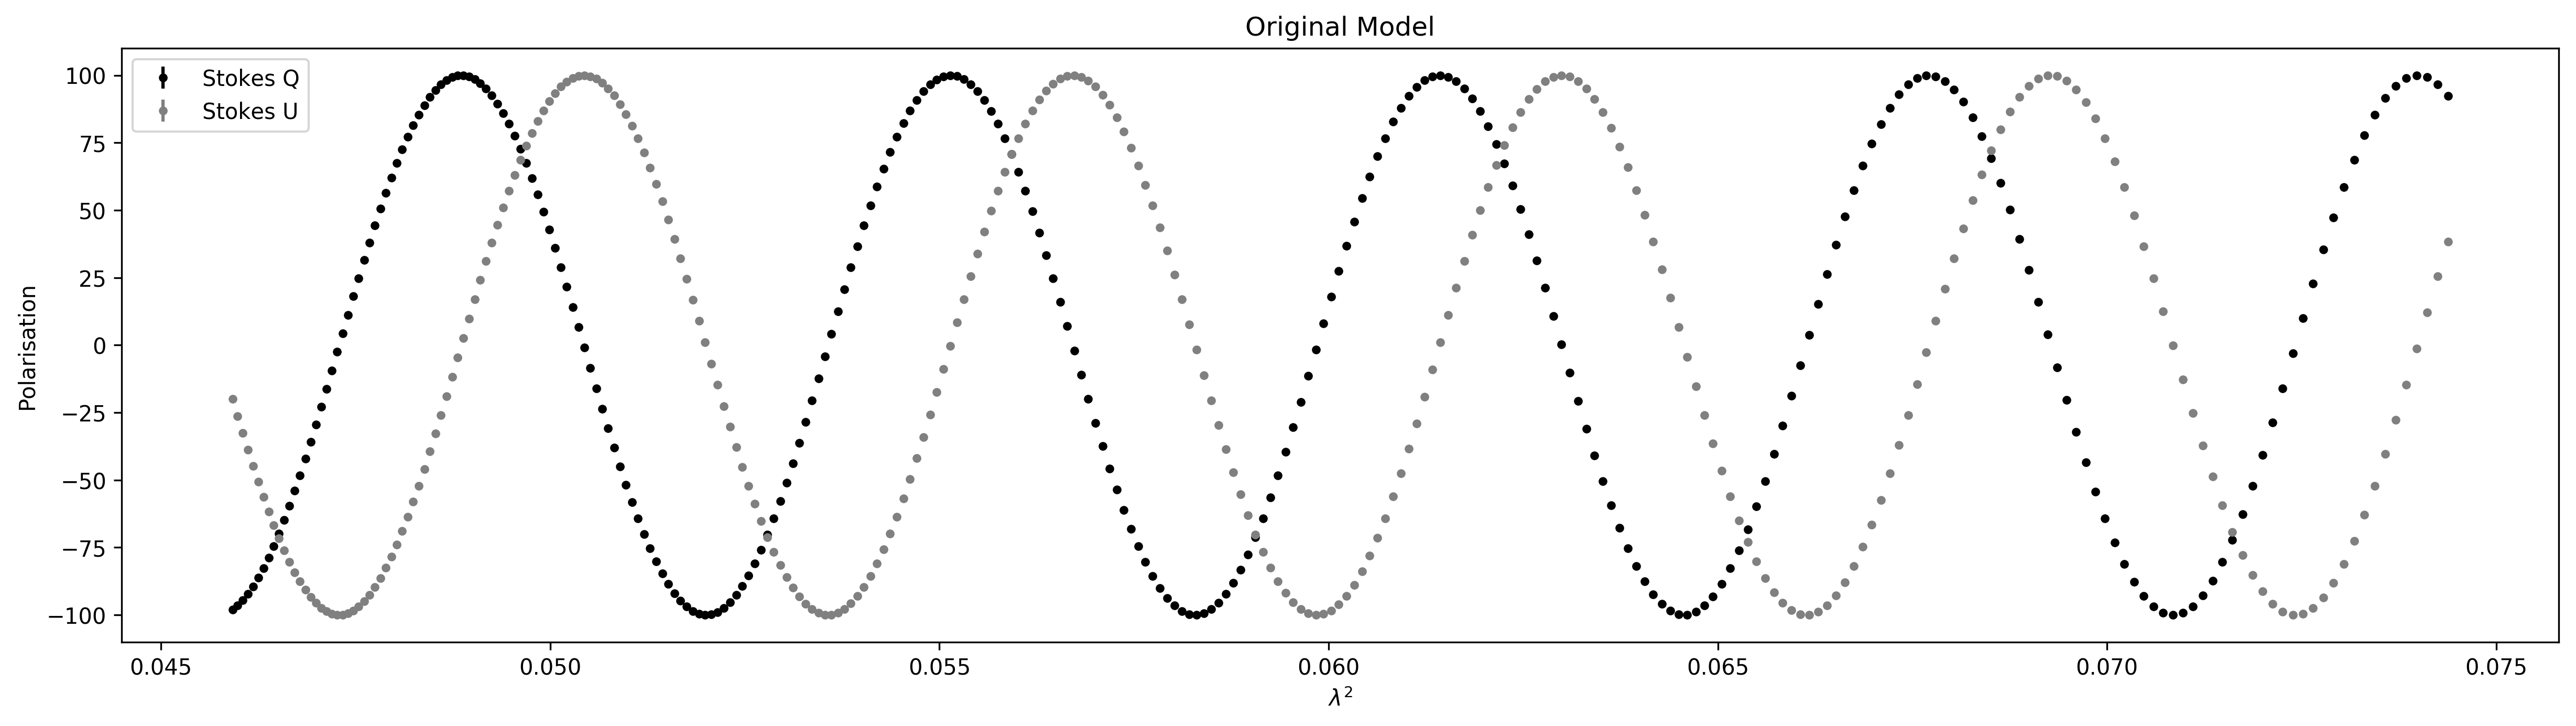

In [8]:
ax = pl.subplot(111)

ax.errorbar(l2[::-1],np.real(p)[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax.errorbar(l2[::-1],np.imag(p)[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax.set_ylabel("Polarisation")
ax.set_xlabel(r"$\lambda^2$")

ax.legend()
pl.title("Original Model")
pl.show()

Normalise the model so that a channel noise of 1 gives SNR=32:

In [9]:
pI = np.mean(np.sqrt(np.real(p)**2+np.imag(p)**2))
snr = pI*np.sqrt(len(l2))
f_snr = 32./snr
p*=f_snr

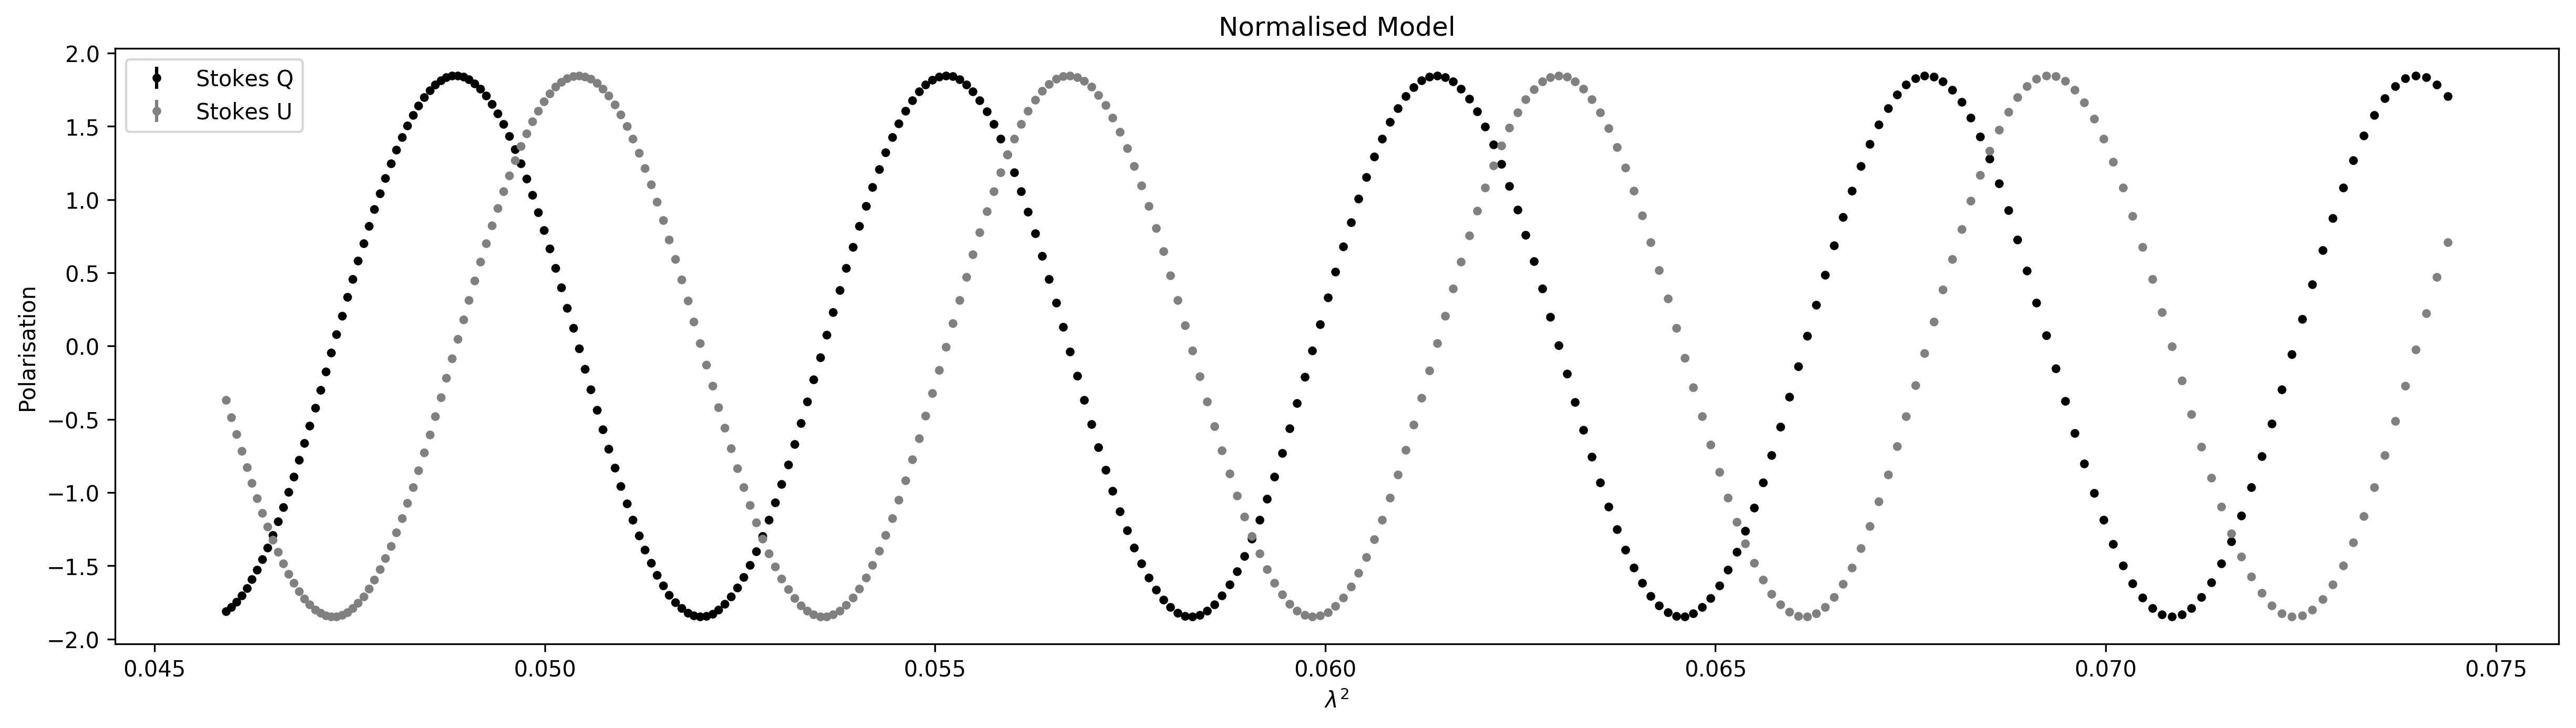

In [10]:
ax = pl.subplot(111)

ax.errorbar(l2[::-1],np.real(p)[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax.errorbar(l2[::-1],np.imag(p)[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax.set_ylabel("Polarisation")
ax.set_xlabel(r"$\lambda^2$")

ax.legend()
pl.title("Normalised Model")
pl.show()

Add noise to the model data:

In [11]:
noise = 1.0
stokesQn = np.real(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))
stokesUn = np.imag(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))

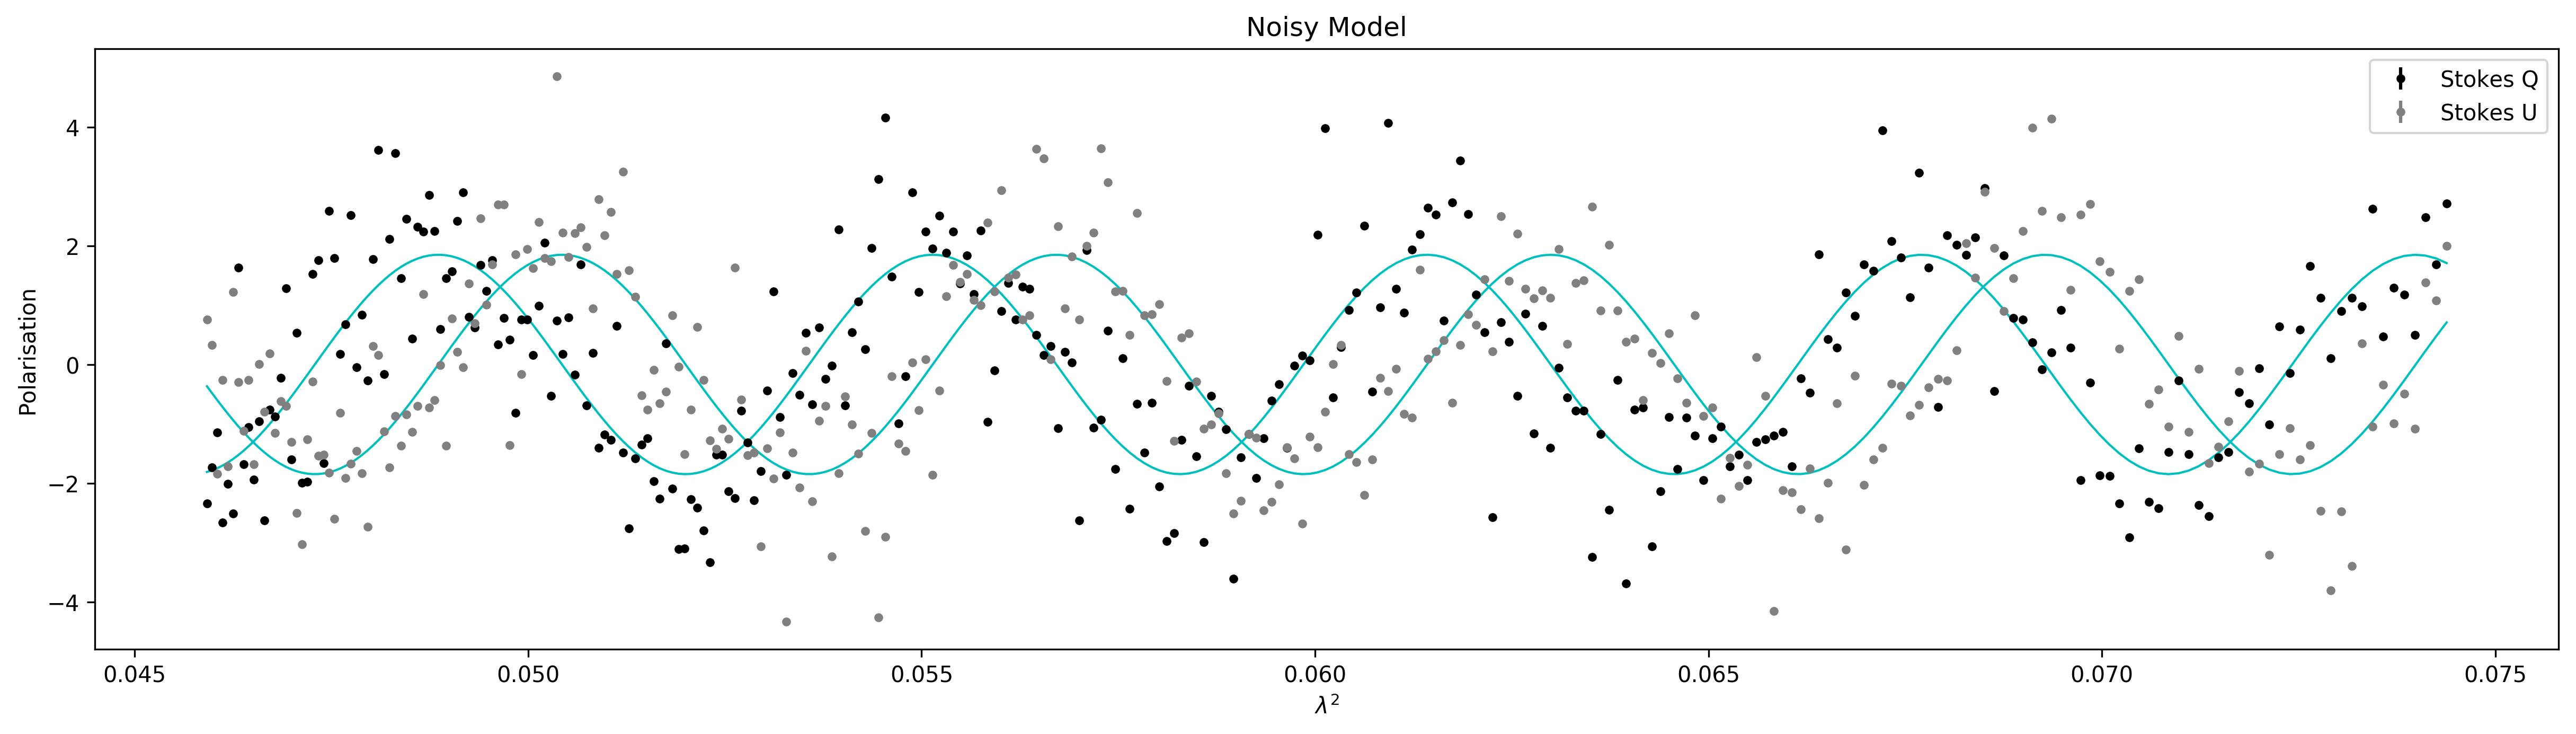

In [12]:
ax = pl.subplot(111)

ax.plot(l2[::-1],np.real(p)[::-1], linestyle='-', color = 'c', lw=1.0)
ax.plot(l2[::-1],np.imag(p)[::-1], color = 'c', lw=1.0)

ax.errorbar(l2[::-1],stokesQn[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax.errorbar(l2[::-1],stokesUn[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax.set_ylabel("Polarisation")
ax.set_xlabel(r"$\lambda^2$")

ax.legend()
pl.title("Noisy Model")
pl.show()

Double check the SNR:

In [13]:
pI = np.mean(np.sqrt(np.real(p)**2+np.imag(p)**2))
snr = pI*np.sqrt(len(l2))/noise
print("SNR: {:2f}".format(snr))

SNR: 32.000000


---
### Loop through models

In [14]:
nmodel = 17

In [16]:
model_msll = []; model_smse = []; model_chi2r = []

for model in tqdm_notebook(range(nmodel)):
    
    # -------------------------------------------------------------------------------------------
    # DATA CREATION
    
    # make the model:
    p = make_model(model,l2)
    
    # normalise the model:
    pI = np.mean(np.sqrt(np.real(p)**2+np.imag(p)**2))
    snr = pI*np.sqrt(len(l2))
    f_snr = 32./snr
    p*=f_snr
    
    # add the noise to Q & U: 
    noise = 1.0
    stokesQn = np.real(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))
    stokesUn = np.imag(p)+np.random.normal(loc =0.0, scale=noise, size = len(p))
    
    # -------------------------------------------------------------------------------------------
    # GP MODELLING
    
    # optimize hyper-parameters of GP and make a prediction:
    GP = MyCelerite(noise)
    GP.celerite_optimize(l2, stokesQn, stokesUn)
    mu_q, std_q, mu_u, std_u = GP.celerite_predict(stokesQn, stokesUn, l2[::-1])

    # calculate the variance for the model:
    gp_var = std_q**2+noise*np.ones(len(std_q))
    
    # -------------------------------------------------------------------------------------------
    # PERFORMANCE METRIC EVALUATION
    
    # create complex stokes:
    stokes = (stokesQn+1j*stokesUn)[::-1]
    
    # calculate CHI2, SMSE, MSLL metrics from Sun et al 2010 paper:
    chi2_r = calc_chi2_r(stokes,mu_q+1j*mu_u,noise*np.ones(len(std_q)))
    smse   = calc_smse(stokes,mu_q+1j*mu_u,noise*np.ones(len(std_q)))
    msll   = calc_sll(stokes,mu_q+1j*mu_u,gp_var)
    
    # -------------------------------------------------------------------------------------------
    # UPDATE OUTPUTS
    
    model_smse.append(smse)
    model_msll.append(msll)
    model_chi2r.append(chi2_r)
    
    if model==0:
        print("Model {}: {: >20} {: >20} {: >20}".format("N","CHI2","SMSE","MSLL"))    
    print("Model {}: {: >20} {: >20} {: >20}".format(model,chi2_r,smse,msll))
    

Model N:                 CHI2                 SMSE                 MSLL
Model 0:       0.866370606957        0.86059480291       -1.46040224096
Model 1:        1.00832049551        1.00159835887        -1.0465190593
Model 2:        1.06145847317        1.05438208335      -0.501349938043
Model 3:        1.12027546748        1.11280696436       -1.07648300507
Model 4:        1.02698972516        1.02014312699      -0.705757725099
Model 5:       0.995726168459       0.989087994002       -0.84542880577
Model 6:       0.945229009476       0.938927482746      -0.584994555349
Model 7:       0.954165015007       0.947803914907       -1.45687799337
Model 8:        1.13583163254        1.12825942166      -0.818216290654
Model 9:       0.985175258848       0.978607423789       -1.09016525355
Model 10:        0.99902236831       0.992362219188       -1.36304771419
Model 11:       0.986979624284       0.980399760122       -1.40153184423
Model 12:          1.008407951        1.00168523133      -0.56

---
### Make plot:

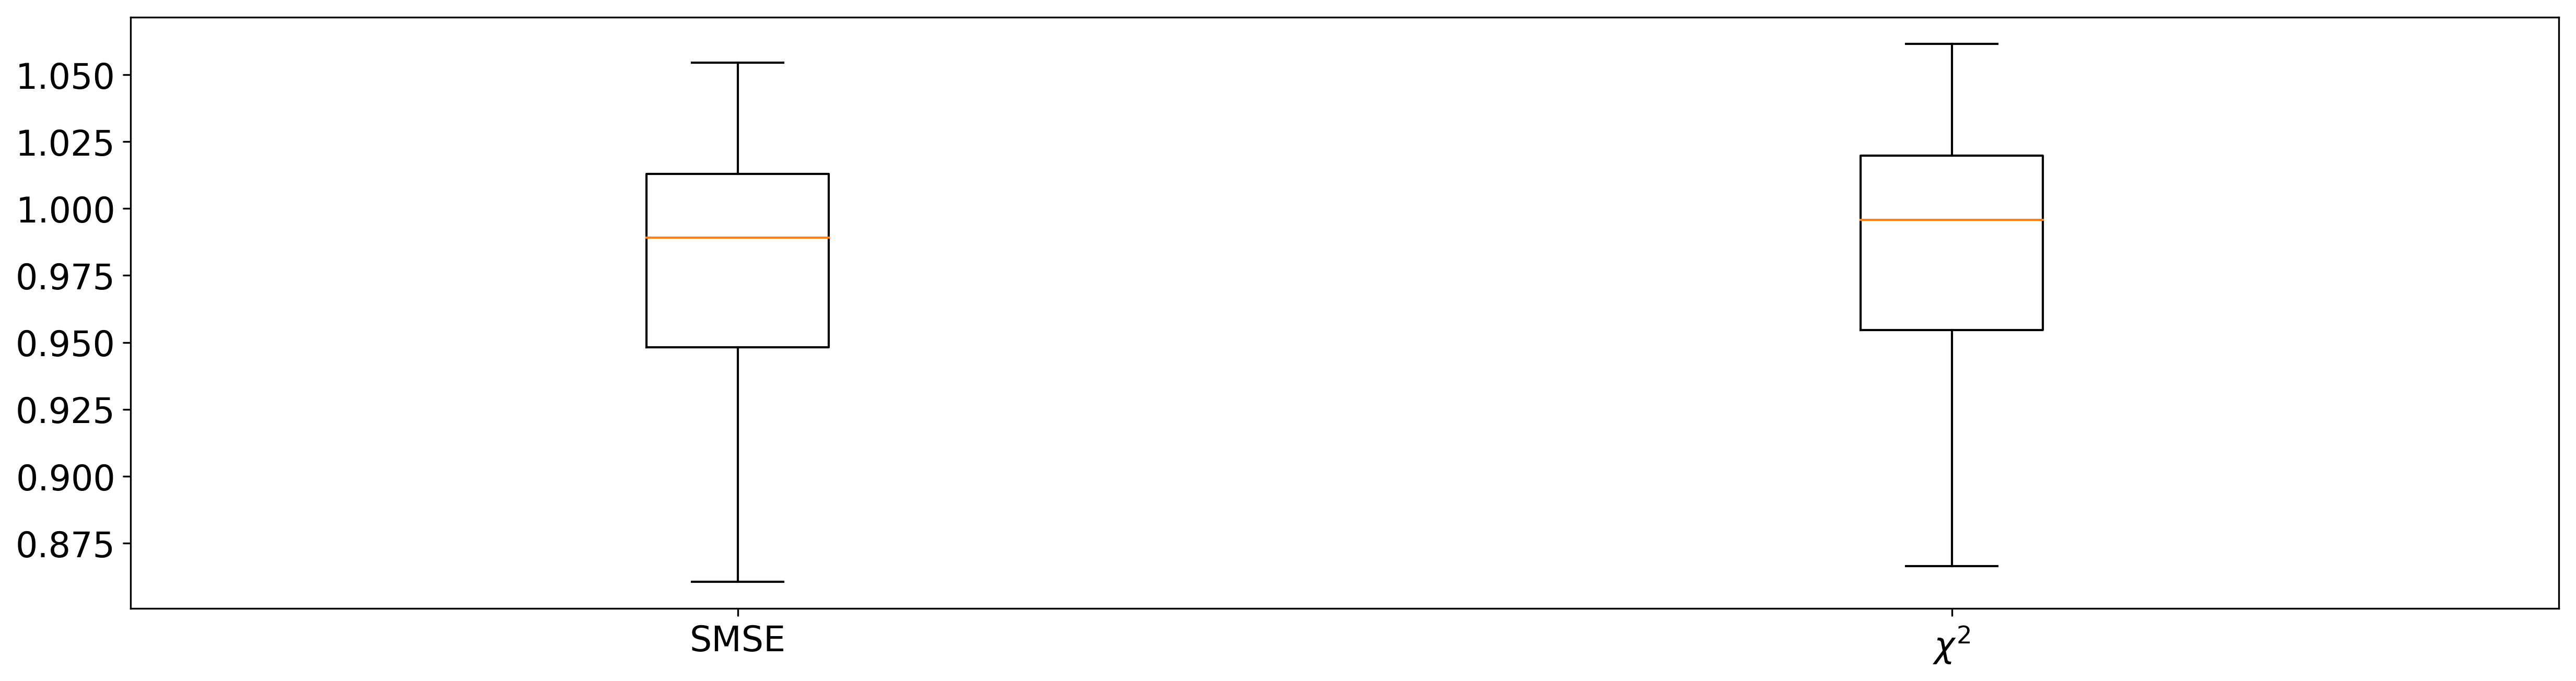

In [17]:
mean_chi2 = [np.median(model_chi2r)]
mean_smse = [np.median(model_smse)]
mean_msll = [np.median(model_msll)]

smsedata = np.concatenate((mean_smse, model_smse))
chi2data = np.concatenate((mean_chi2, model_chi2r))
mslldata = np.concatenate((mean_msll, model_msll))

data1 = [smsedata, chi2data]

fig1, ax1 = pl.subplots()
ax1.boxplot(data1, showfliers=False)
pl.xticks([1, 2], ['SMSE', r'$\chi^2$'], fontsize=16)
pl.yticks(fontsize=16)
pl.show()

---
#### END